<a href="https://colab.research.google.com/github/ritusinha128/health-informatics-project/blob/main/Chest_Cancer_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving Kaggle.json to Kaggle.json


{'Kaggle.json': b'{"username":"harshithasanjeev","key":"75dae23f53cb9eb626e75bc420c8f7e9"}'}

In [ ]:
from google.colab import files
files.upload()

Saving Kaggle.json to Kaggle (1).json


{'Kaggle (1).json': b'{"username":"harshithasanjeev","key":"75dae23f53cb9eb626e75bc420c8f7e9"}'}

In [2]:
!mkdir ~/.kaggle

In [3]:
!cp Kaggle.json ~/.kaggle/kaggle.json

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d unaissait/curated-chest-xray-image-dataset-for-covid19

100% 3.48G/3.49G [00:50<00:00, 68.0MB/s]
100% 3.49G/3.49G [00:50<00:00, 74.3MB/s]


In [6]:
import zipfile
import os

# Define the path to the zip file and the extraction directory
zip_file_path = '/content/curated-chest-xray-image-dataset-for-covid19.zip'
extraction_directory = '/content'

# Check if the extraction directory exists, create if it does not
if not os.path.exists(extraction_directory):
    os.makedirs(extraction_directory)

# Unzipping the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_directory)

print(f'Files extracted to {extraction_directory}')

Files extracted to /content


In [7]:
import os
import cv2
import time
import torch
import numpy as np
import matplotlib.pyplot as plt


from torch import nn
from typing import Any
from torch.backends import mps
from torchvision import models
from tqdm.notebook import tqdm
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torch.utils.tensorboard import SummaryWriter


bar = "="
version = torch.__version__
writer = SummaryWriter('./logs')

if mps.is_available() :
    device = torch.device('mps')
elif torch.cuda.is_available() :
    device = torch.device('cuda')
else :
    device = torch.device('cpu')

print(f'{bar*10}Device INFO{bar*10}')
print(f'PyTorch Version :{version}')
print(f'Device :{device}')
print(bar*31)

==========Device INFO==========
PyTorch Version :2.2.1+cu121
Device :cuda


In [8]:
transformer = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomGrayscale(p=0.5),
    transforms.ColorJitter(saturation=0.5),
    transforms.ToTensor()
])

In [9]:
lable_name = ['Covid', 'Normal',  'Pneumonia Bacterial']#, 'Viral Pneumonia']
dataset = ImageFolder('../content/Curated X-Ray Dataset/', transform=transformer)
dataset.classes

['COVID-19', 'Normal', 'Pneumonia-Bacterial', 'Pneumonia-Viral']

In [10]:
COV_DIR = "/content/Curated X-Ray Dataset/COVID-19"
NORM_DIR = "/content/Curated X-Ray Dataset/Normal"
BAC_DIR = "/content/Curated X-Ray Dataset/Pneumonia-Bacterial"
#VIR_DIR = "/content/Curated X-Ray Dataset/Pneumonia-Viral"

In [11]:
folder = os.makedirs ('/kaggle/working/dataset', exist_ok=True)

In [12]:
directories = {
    'covid-19': "/content/Curated X-Ray Dataset/COVID-19",
    'Normal': "/content/Curated X-Ray Dataset/Normal",
    'bacterial': "/content/Curated X-Ray Dataset/Pneumonia-Bacterial",
    #'viral': "/content/Curated X-Ray Dataset/Pneumonia-Viral"
}


# Count the number of images in each directory
for class_name, directory in directories.items():
    num_images = len(os.listdir(directory))
    print(f"Number of images in {class_name} directory: {num_images}")

Number of images in covid-19 directory: 1281
Number of images in Normal directory: 3270
Number of images in bacterial directory: 3001


In [13]:
from sklearn.model_selection import train_test_split

data_train=[]
labels_train=[]
data_test=[]
labels_test=[]
data_val=[]
labels_val=[]

COVID_files = os.listdir(COV_DIR)
Normal_files = os.listdir(NORM_DIR)
Bacterial_files = os.listdir(BAC_DIR)
#Viral_files = os.listdir(VIR_DIR)

In [14]:
def wb(channel, perc = 0.05):
    mi, ma = (np.percentile(channel, perc), np.percentile(channel,100.0-perc))
    channel = np.uint8(np.clip((channel-mi)*255.0/(ma-mi), 0, 255))
    return channel

In [15]:
COVID_train_files, COVID_test_files = train_test_split(COVID_files, test_size=0.20, random_state=42)
COVID_train_files, COVID_val_files = train_test_split(COVID_train_files, test_size=0.20, random_state=42)

Normal_train_files, Normal_test_files = train_test_split(Normal_files, test_size=0.20, random_state=42)
Normal_train_files, Normal_val_files = train_test_split(Normal_train_files, test_size=0.20, random_state=42)

Bacterial_train_files, Bacterial_test_files = train_test_split(Bacterial_files, test_size=0.20, random_state=42)
Bacterial_train_files, Bacterial_val_files = train_test_split(Bacterial_train_files, test_size=0.20, random_state=42)

#Viral_train_files, Viral_test_files = train_test_split(Viral_files, test_size=0.20, random_state=42)
#Viral_train_files, Viral_val_files = train_test_split(Viral_train_files, test_size=0.20, random_state=42)

In [16]:
for a in COVID_train_files:
    image = cv2.imread(os.path.join(COV_DIR, a))
    # performing white balance
    imWB  = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)] )
    gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(img, (224, 224))
    data_train.append(image)
    labels_train.append(0)

for a in COVID_test_files:
    image = cv2.imread(os.path.join(COV_DIR, a))
    # performing white balance
    imWB  = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)] )
    gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(img, (224, 224))
    data_test.append(image)
    labels_test.append(0)

for a in COVID_val_files:
    image = cv2.imread(os.path.join(COV_DIR, a))
    # performing white balance
    imWB  = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)] )
    gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(img, (224, 224))
    data_val.append(image)
    labels_val.append(0)

In [17]:
for b in Normal_train_files:
    image = cv2.imread(os.path.join(NORM_DIR, b))
    imWB  = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)] )
    gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(img, (224, 224))
    data_train.append(image)
    labels_train.append(1)

for b in Normal_test_files:
    image = cv2.imread(os.path.join(NORM_DIR, b))
    imWB  = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)] )
    gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(img, (224, 224))
    data_test.append(image)
    labels_test.append(1)

for b in Normal_val_files:
    image = cv2.imread(os.path.join(NORM_DIR, b))
    imWB  = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)] )
    gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(img, (224, 224))
    data_val.append(image)
    labels_val.append(1)

In [18]:
for c in Bacterial_train_files:
    image = cv2.imread(os.path.join(BAC_DIR, c))
    # performing white balance
    imWB  = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)] )
    gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(img, (224, 224))
    data_train.append(image)
    labels_train.append(2)

for c in Bacterial_test_files:
    image = cv2.imread(os.path.join(BAC_DIR, c))
    # performing white balance
    imWB  = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)] )
    gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(img, (224, 224))
    data_test.append(image)
    labels_test.append(2)

for c in Bacterial_val_files:
    image = cv2.imread(os.path.join(BAC_DIR, c))
    # performing white balance
    imWB  = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)] )
    gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(img, (224, 224))
    data_val.append(image)
    labels_val.append(2)

In [ ]:
for c in Viral_train_files:
    image = cv2.imread(os.path.join(VIR_DIR, c))
    # performing white balance
    imWB  = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)] )
    gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(img, (224, 224))
    data_train.append(image)
    labels_train.append(3)

for c in Viral_test_files:
    image = cv2.imread(os.path.join(VIR_DIR, c))
    # performing white balance
    imWB  = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)] )
    gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(img, (224, 224))
    data_test.append(image)
    labels_test.append(3)

for c in Viral_val_files:
    image = cv2.imread(os.path.join(VIR_DIR, c))
    # performing white balance
    imWB  = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)] )
    gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(img, (224, 224))
    data_val.append(image)
    labels_val.append(3)

In [19]:
print("Number of images in train lists :")
print("COVID-19:", labels_train.count(0))
print("Normal:", labels_train.count(1))
print("Pneumonia-Bacterial:", labels_train.count(2))
#print("Pneumonia-Viral:", labels_train.count(3))

print("\n Number of images in test lists :")
print("COVID-19:", labels_test.count(0))
print("Normal:", labels_test.count(1))
print("Pneumonia-Bacterial:", labels_test.count(2))
#print("Pneumonia-Viral:", labels_test.count(3))

print("\n Number of images in validation lists :")
print("COVID-19:", labels_val.count(0))
print("Normal:", labels_val.count(1))
print("Pneumonia-Bacterial:", labels_val.count(2))
#print("Pneumonia-Viral:", labels_val.count(3))

Number of images in train lists :
COVID-19: 819
Normal: 2092
Pneumonia-Bacterial: 1920

 Number of images in test lists :
COVID-19: 257
Normal: 654
Pneumonia-Bacterial: 601

 Number of images in validation lists :
COVID-19: 205
Normal: 524
Pneumonia-Bacterial: 480


In [20]:
x_train = np.array (data_train)
y_train = np.array (labels_train)

x_test = np.array (data_test)
y_test = np.array (labels_test)

x_val = np.array (data_val)
y_val = np.array (labels_val)

In [21]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

# Check the shapes of the resulting sets
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("x_val shape:", x_val.shape)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("y_val shape:", y_val.shape)

x_train shape: (4831, 224, 224, 3)
x_test shape: (1512, 224, 224, 3)
x_val shape: (1209, 224, 224, 3)
y_train shape: (4831, 3)
y_test shape: (1512, 3)
y_val shape: (1209, 3)


In [22]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=15,
    horizontal_flip=True,
    fill_mode="nearest")

batch_size = 32
image_size = (224, 224)

train_dataset = datagen.flow(x_train,
                            y_train,
                             batch_size=batch_size,
                             shuffle=True)

test_dataset = datagen.flow(x_test,
                            y_test,
                            batch_size=batch_size,
                            shuffle=True)

validation_dataset = datagen.flow(x_val,
                                  y_val,
                                  batch_size=batch_size,
                                  shuffle=False)

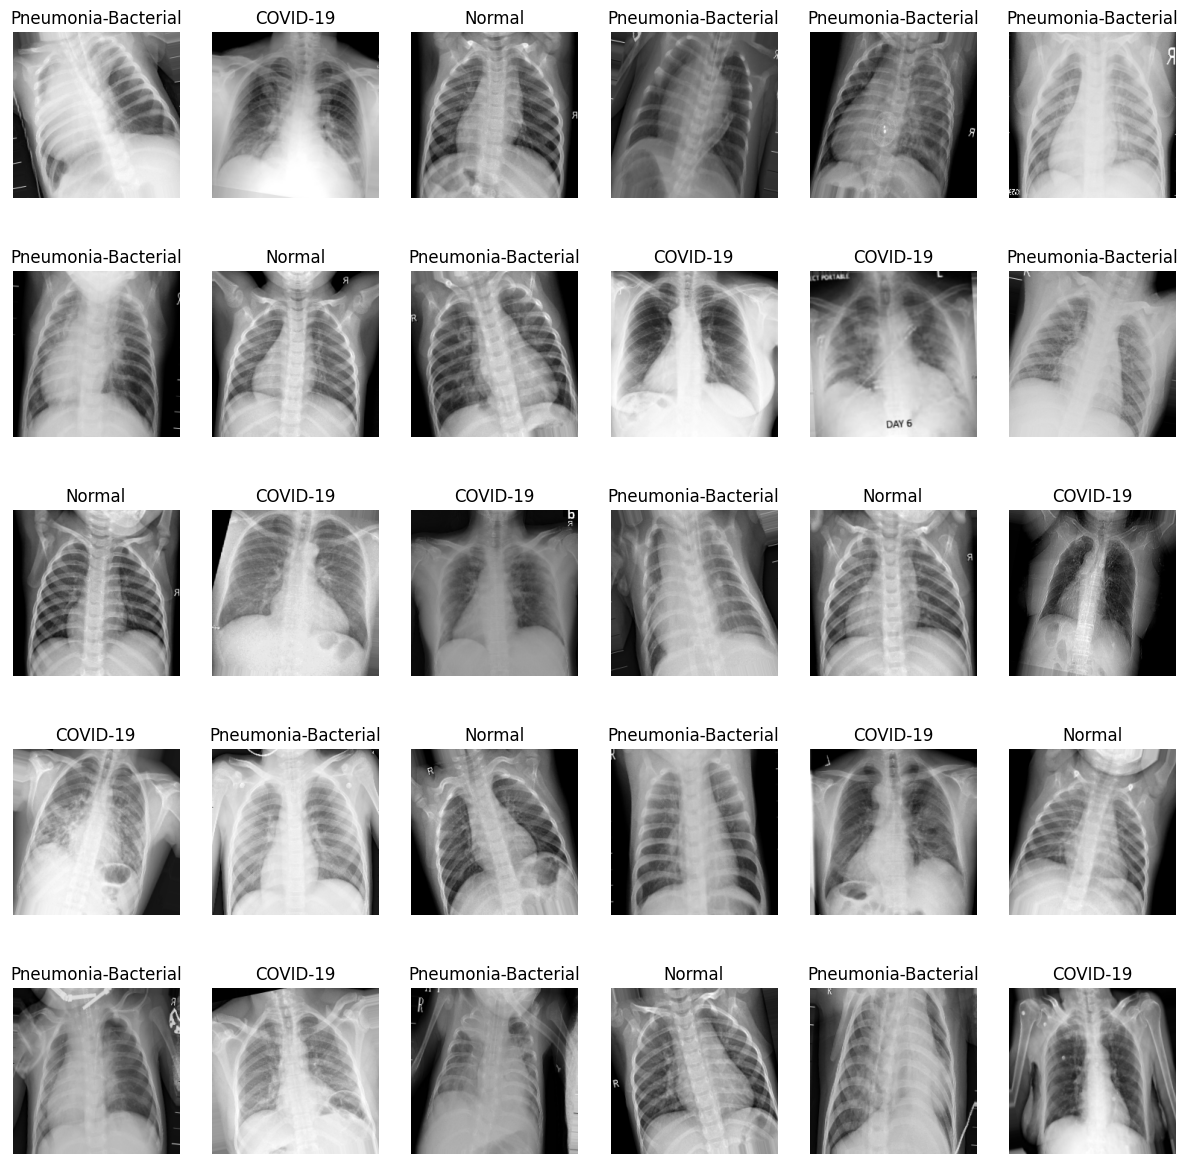

In [23]:
import matplotlib.pyplot as plt

# Get the first batch from the train dataset
batch_images, batch_labels = train_dataset.next()

# Define class names
class_names = ['COVID-19', 'Normal', 'Pneumonia-Bacterial', 'Pneumonia-Viral']

# Plot the first 30 images
plt.figure(figsize=(15, 15))
for i in range(30):
    plt.subplot(5, 6, i + 1)
    plt.imshow(batch_images[i])
    plt.title(class_names[np.argmax(batch_labels[i])])
    plt.axis("off")

plt.show()

In [24]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Input, concatenate
from tensorflow.keras.applications import MobileNetV2, VGG16
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

input_shape = (224, 224, 3)
num_classes = 3

# Define input layer
input_layer = Input(shape=input_shape)

vgg16_base = VGG16(weights='imagenet',
                   input_shape=input_shape,
                   include_top=False)

for layer in vgg16_base.layers:
    layer.trainable = False

# Define output layers for VGG16
model_vgg = vgg16_base(input_layer)
model_vgg = GlobalAveragePooling2D()(model_vgg)
output_vgg = Flatten()(model_vgg)

# Load base models
mobilenet_base = MobileNetV2(weights='imagenet',
                             input_shape=input_shape,
                             include_top=False)

# Freeze base models
for layer in mobilenet_base.layers:
    layer.trainable = False

# Define output layers for MobileNetV2
model_mobilenet = mobilenet_base(input_layer)
model_mobilenet = GlobalAveragePooling2D()(model_mobilenet)
output_mobilenet = Flatten()(model_mobilenet)

# Concatenate output layers
merged_output = concatenate([output_vgg, output_mobilenet], axis=-1)

# Define final model
model = Sequential([
    Model(inputs=input_layer, outputs=merged_output),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

9406464/9406464 [==============================] - 0s 0us/step


In [25]:
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.layers import Activation
input_shape = (224,224,3)
input_layer = Input(shape = (224, 224, 3))
num_clases = 4

model = Sequential()

#Block Number 1
model.add(Conv2D(input_shape = (224,224,3), filters=32,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(Conv2D(filters=32,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(MaxPool2D((2,2)))

#Block Number 2
model.add(Conv2D(filters=64,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(Conv2D(filters=128,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(MaxPool2D((2,2)))

#Block Number 3
model.add(Conv2D(filters=256,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(Conv2D(filters=512,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(MaxPool2D((2,2)))

model.add(MaxPool2D((2,2)))

# Fully Connected layer
model.add(Flatten())

model.add(Dense(units=512, activation="relu"))
model.add(Dropout(rate=0.2))

model.add(Dense(units=3, activation="softmax"))

In [26]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', "AUC"])
# Show model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 activation (Activation)     (None, 224, 224, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      18496     
                                                      

In [27]:
from keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(monitor='val_loss', patience=5)


stacked_history = model.fit(train_dataset,
                            epochs=50,
                            validation_data=validation_dataset,
                            batch_size=64)

Epoch 1/50
151/151 [==============================] - 108s 584ms/step - loss: 0.5411 - accuracy: 0.7822 - auc: 0.9276 - val_loss: 0.4195 - val_accuracy: 0.8677 - val_auc: 0.9599
Epoch 2/50
151/151 [==============================] - 78s 512ms/step - loss: 0.2596 - accuracy: 0.9069 - auc: 0.9803 - val_loss: 0.2519 - val_accuracy: 0.9024 - val_auc: 0.9824
Epoch 3/50
151/151 [==============================] - 76s 501ms/step - loss: 0.1888 - accuracy: 0.9290 - auc: 0.9892 - val_loss: 0.1858 - val_accuracy: 0.9297 - val_auc: 0.9898
Epoch 4/50
151/151 [==============================] - 77s 511ms/step - loss: 0.1903 - accuracy: 0.9346 - auc: 0.9887 - val_loss: 0.2145 - val_accuracy: 0.9297 - val_auc: 0.9866
Epoch 5/50
151/151 [==============================] - 76s 502ms/step - loss: 0.1838 - accuracy: 0.9360 - auc: 0.9892 - val_loss: 0.1905 - val_accuracy: 0.9371 - val_auc: 0.9888
Epoch 6/50
151/151 [==============================] - 77s 509ms/step - loss: 0.1569 - accuracy: 0.9476 - auc: 0.99

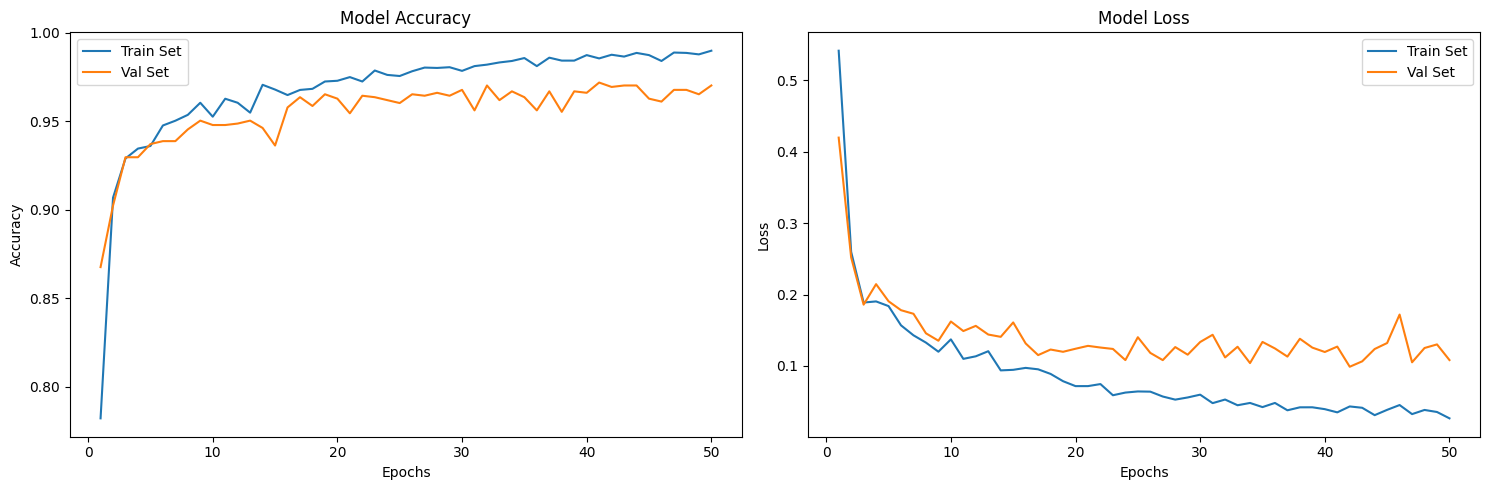

In [28]:
acc = stacked_history.history['accuracy']
val_acc = stacked_history.history['val_accuracy']
loss = stacked_history.history['loss']
val_loss = stacked_history.history['val_loss']
epochs_range = range(1, len(stacked_history.epoch) + 1)
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.tight_layout()
plt.show()

In [29]:
# checking the accuracy
accuracy = model.evaluate(test_dataset, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

48/48 [==============================] - 19s 391ms/step - loss: 0.0656 - accuracy: 0.9808 - auc: 0.9959

 Test_Accuracy:- 0.9808201193809509


In [30]:
predect = model.predict(x_test, batch_size=16, verbose=0)
predect[1]

array([0., 0., 1.], dtype=float32)

95/95 [==============================] - 3s 28ms/step


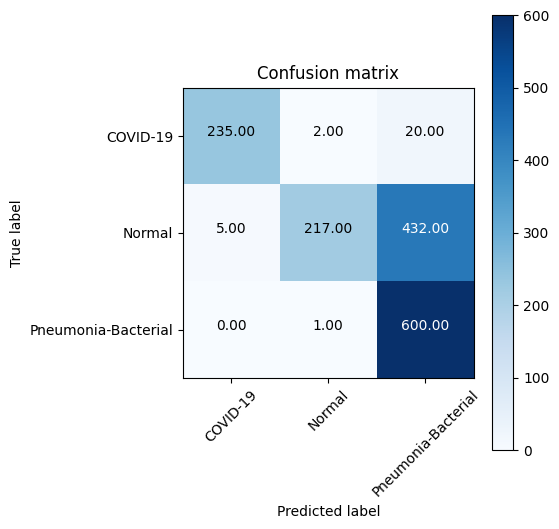

In [31]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

pred = np.argmax(predect, axis=1)
rounded_labels = np.argmax(y_test, axis=1)

pred_Y = model.predict(x_test, batch_size=16, verbose=True)
BS = 16

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(6, 6))  # تحديد حجم الشكل
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    target_names = ['COVID-19', 'Normal', 'Pneumonia-Bacterial']

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout(pad=3.0)  # تحسين تنسيق الرسم البياني
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
pred_Y = model.predict(x_test, batch_size=16, verbose=True)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(pred_Y, axis=1)
# Convert validation observations to one hot vectors
# compute the confusion matrix
rounded_labels = np.argmax(y_test, axis=1)
confusion_mtx = confusion_matrix(rounded_labels, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes=range(3))


In [34]:
from sklearn.metrics import classification_report
presIdxs = model.predict (x_test, batch_size = BS)

'''
for each image in the testing set we need to find the index of the label
with corresponding largest predict probability
'''
presIdxs = np.argmax (presIdxs, axis = 1)
rounded_labels = np.argmax (y_test, axis = 1)

# show a nicely formatted classification report
target_names =['COVID-19', 'Normal', 'Pneumonia-Bacterial']
print (classification_report(rounded_labels, presIdxs, target_names = target_names))

95/95 [==============================] - 3s 30ms/step
                     precision    recall  f1-score   support

           COVID-19       0.98      0.91      0.95       257
             Normal       0.99      0.33      0.50       654
Pneumonia-Bacterial       0.57      1.00      0.73       601

           accuracy                           0.70      1512
          macro avg       0.85      0.75      0.72      1512
       weighted avg       0.82      0.70      0.66      1512



48/48 [==============================] - 3s 58ms/step


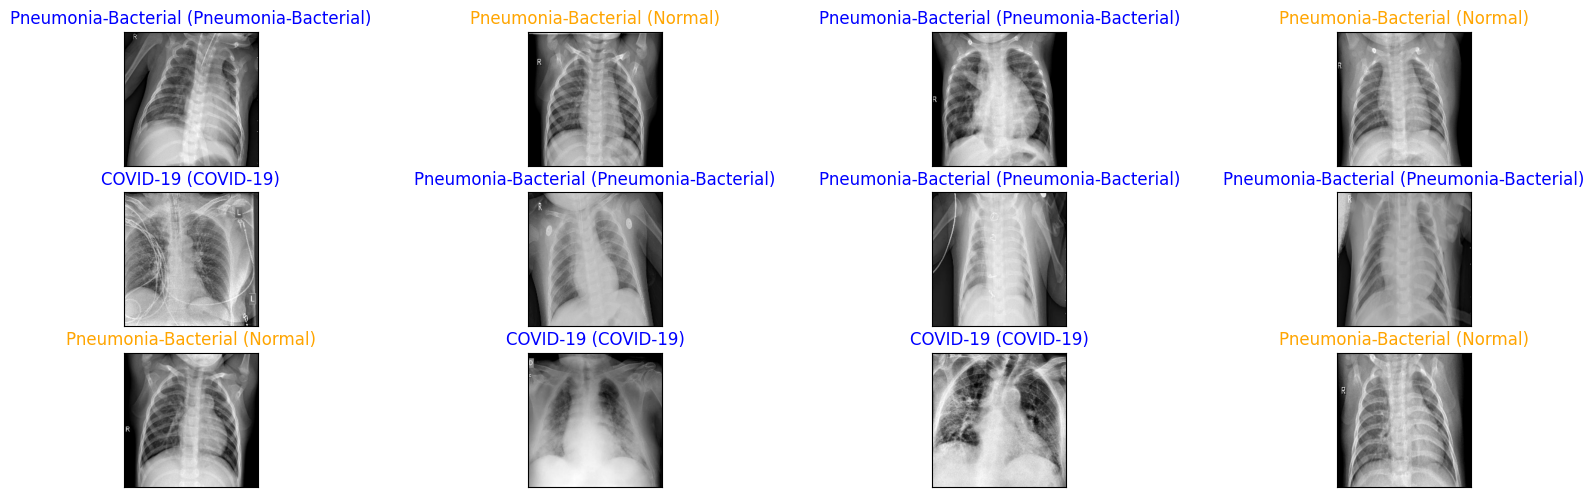

In [35]:
y_hat = model.predict(x_test)
# define text labels
cxr_labels = ['COVID-19', 'Normal', 'Pneumonia-Bacterial']
# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=12, replace=False)):
    ax = fig.add_subplot(4,4, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(cxr_labels[pred_idx], cxr_labels[true_idx]),
            color=("blue" if pred_idx == true_idx else "orange"))

In [36]:
model.save('/kaggle/working/Covid-19.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [37]:
import tensorflow as tf

# Load the model from .h5 file
model = tf.keras.models.load_model('/kaggle/working/Covid-19.h5')

# Convert the model to TensorFlow Lite format (.tflite)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model in .tflite format
with open('/kaggle/working/Covid-19.tflite', 'wb') as f:
    f.write(tflite_model)